# Hotel Lift Traffic: Monte Carlo simulation

In [51]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import logging
import random
import math

logging.getLogger(__name__).setLevel(logging.DEBUG)
logging.debug("TEST")

%matplotlib inline

In [3]:
# make a rules using graph network
lift_number = 4
number_of_floor = 20
conference_room_floor = 2

In [132]:
class RoomType:
    def __init__(self,name_type:str,capacity:int):
        self._name_type=name_type
        self._capacity=capacity
    
    @property
    def name_type(self):
        return self._name_type
    
    @property
    def capacity(self):
        return self._capacity

class Room(RoomType):
    """
    def __init__(self,number: str,room_type: RoomType):
        self._room_type = room_type
        self._number = number        
        
    @property
    def room_type(self):
        return self._room_type
    """
        
    def __init__(self,number: str,name:str,capacity:int):
        RoomType.__init__(self,name,capacity)
        self._number = number
    
    @property
    def number(self):
        return self._number
                
    def __repr__(self):
        return("Room {}, Type: {}, Capacity: {}".format(self.number,self.name_type,self.capacity))

        
class RandomDist():
    def __init__(self,name):
        self._name = name

    @property
    def name(self):
        return self._name
    
    def random(self):
        None
    
class GaussianDist(RandomDist):
    def __init__(self,mu:float,sigma:float,low:float,high:float):
        RandomDist.__init__(self,"Gaussian")
        self._mu = mu
        self._sigma = sigma
        self._low = low
        self._high = high
        
    def random(self):
        x = self._low - 1
        while x < self._low or x > self._high:
            x = random.gauss(self._mu,self._sigma)                        
        return x

class CapacityLimit:
    def __init__(self,capacity = 0):
        self._capacity = capacity
    
    @property
    def capacity(self):
        return self._capacity

class Floor(CapacityLimit):
    def __init__(self,capacity = 0):
        CapacityLimit.__init__(self,capacity)
    
class HotelFloor(Floor):
    def __init__(self,floor_name:str,rooms_floor_count: dict,room_types: dict):
        self._rooms = {}
        number = 1
        self._floor_name = floor_name
        
        capacity = 0
        # initialize room type
        for key in rooms_floor_count:
            self._rooms[key] = []
        # create the Room object
        for key in rooms_floor_count:
            for i in range(rooms_floor_count[key]):
                room = Room(str(floor_name)+str(number),room_types[key].name_type,room_types[key].capacity)
                self._rooms[key].append(room)
                capacity += room.capacity
                number+=1
        
        Floor.__init__(self,capacity)
    
    @property
    def rooms(self):
        return self._rooms
    
        

class Lift(CapacityLimit):    
    def __init__(self,name:str,average_speed:int=1,
                 floor_configuration:dict={},capacity:int = 0,position:int = 0,
                 max_waiting_time:int=10):
        CapacityLimit.__init__(self,capacity)
        self._name = name
        self._position = position
        self._graph = nx.DiGraph()
        self._attendance = 0
        self._max_waiting_time = 10
        
        # Random distribution for maximum waiting time
        # it should use skewed distribution
        # This will effect the lift door closing time
        
        self._random_gauss = GaussianDist(mu = self.max_waiting_time/2, sigma=5, low=1, high=self.max_waiting_time)

        if len(floor_configuration) > 0:
            # floor configuration is exist
            # we can make a fully customized lift graph
            logging.debug(floor_configuration)
            self._served_floor = floor_configuration["floor"]
            for i,x in enumerate(floor_configuration["floor"]):
                self.graph.add_node(x)
                if i > 0:
                    previous_floor = floor_configuration["floor"][i-1]
                    speed = floor_configuration["speed"][i-1]
                    self.graph.add_edge(previous_floor,x,attr={"speed": speed, "dir": "up"})
                    self.graph.add_edge(x,previous_floor,attr={"speed": speed, "dir": "down"})
    
    @property
    def max_waiting_time(self):
        return self._max_waiting_time
    
    @property
    def random_gauss(self) -> GaussianDist :
        return self._random_gauss
    
    def gen_close_door(self) -> int :
        """
        Generate close door for simulation
        """
        return math.ceil(self._random_gauss.random())
                    
    @property
    def waiting_time(self) -> int :
        return self._waiting_time
                    
    @property
    def name(self) -> str :
        return self._name
    
    @property
    def position(self) -> int : 
        return self._position
    
    @position.setter
    def position(self,position) -> int :
        self._position = position
        
    @property
    def graph(self) -> nx.DiGraph : 
        return self._graph
    
    @property
    def attendance(self) -> int : 
        return self._attendance

    @property
    def served_floor(self) -> list:
        return self._served_floor
    
    @attendance.setter
    def attendance(self, new_att:int):
        if new_att > self.capacity:
            raise Exception("Attendance reach it's maximum capacity: {}".format(self.capacity))
        if new_att < 0:
            raise Exception("Attendance can't be lower than zero: {}".format(new_att))
        """
        if self.attendance + new_att > self.capacity:
            throw Exception("Attendance reach it's maximum capacity: {}".format(self.capacity))
        """
        self._attendance = new_att
    
    def add_attendance(self,new_att: int):
        self.attendance+=new_att
    
    def pop_attendance(self,drop_att: int):
        self.attendance-=drop_att            
    
    def go_up(self):
        edge = self.graph.edge[self.position]
        for target_node in edge:
            if edge[target_node]["attr"]["dir"] == "up":
                self.position = target_node
        return self.position
    
    def go_down(self):
        edge = self.graph.edge[self.position]
        for target_node in edge:
            if edge[target_node]["attr"]["dir"] == "down":
                self.position = target_node
        return self.position

    def __repr__(self):
        #print(self.served_floor)
        return "Lift {}, capacity: {}, attendance: {}, position: {}, serve: {}".format(self.name,self.capacity,self.attendance,self.position,",".join([str(x) for x in self.served_floor])) 
        
        
number_of_floor = 20

custom_floor = [0,10]
custom_floor.extend(range(11,number_of_floor))
custom_speed = [10]
custom_speed.extend([1 for x in range(10,number_of_floor-1)])


lift_floor_configuration = {
    # speed 1 for every floor
    0: { "floor": range(0,number_of_floor), "speed": [1 for x in range(number_of_floor-1)] },
    1: { "floor": range(0,number_of_floor), "speed": [1 for x in range(number_of_floor-1)] }, 
    2: { "floor": range(0,int(number_of_floor/2)), "speed": [1 for x in range(0,int(number_of_floor/2)-1)] },
    3: { "floor": range(0,int(number_of_floor/2)), "speed": [1 for x in range(0,int(number_of_floor/2)-1)] },
    4: { "floor": custom_floor, "speed": custom_speed },
    5: { "floor": custom_floor, "speed": custom_speed }
}

room_types_list = ["single","double","deluxe"]

room_types = {
    "single": RoomType("single",2),
    "double": RoomType("double",2),
    "deluxe": RoomType("deluxe",4),
}

rooms_floor_count = {
    "single" : 20,
    "double" : 20,
    "deluxe" : 10
}    
    
class HotelLift():    
    def __init__(self,number_of_floor:int,number_of_lift:int,rooms_floor_count,room_types:dict):
        self._floors = []
        self._rooms = []
        self._total_capacity = 0
        for x in range(number_of_floor):
            floor = HotelFloor(x,rooms_floor_count,room_types)
            self._total_capacity += floor.capacity
            self._floors.append(floor)
            #print(floor.rooms)
            for rooms in floor.rooms.values():
                #print(rooms)
                self._rooms.extend(rooms)
        
        self._lifts = {}
        for x in lift_floor_configuration:
            logging.debug(x)
            config = lift_floor_configuration[x]
            self.lifts[x] = Lift(name=x,floor_configuration=config,capacity=20,position=0)
            
        """
        for x in range(number_of_lift):
            lift = Lift(x,20,0)
            for y in range(number_of_floor):
                lift.graph.add_node(y)
                if y > 0:
                    lift.graph.add_edge(y-1,y)
                    lift.graph.add_edge(y,y-1)

            self._lifts.append(lift)     
        """
        
    @property
    def lifts(self):
        return self._lifts
    
    @property
    def floors(self):
        return self._floors
    
    @property
    def rooms(self):
        return self._rooms
    
    @property
    def total_capacity(self):
        return self._total_capacity
    
    def __repr__(self):
        output = ""
        for x in self.lifts.values():
            output += x.__repr__() + "\n"
        return output
                        
        
def create_lift(number_of_floor:int):
    one_lift = nx.DiGraph()
    for x in range(number_of_floor):
        one_lift.add_node(x)
        if x > 0:
            one_lift.add_edge(x-1,x)
            one_lift.add_edge(x,x-1)
    return one_lift

In [133]:
class Person():
    def __init__(self,schedule={},capacity_unit=1):
        self._capacity_unit = capacity_unit
        self._schedule = schedule
    
    @property
    def capacity_unit(self):
        return self._capacity_unit
            

In [189]:
class AttendanceGenerator():    
    def __init__(self,room_stack : list,time_range:int):
    #def __init__(self,time_range:int):
        """
        time_range: is distribution time between each attendance
        """
        self._room_stack = room_stack
        #self._dist_time = dist_time
        self._time_range = time_range
        self._generate = GaussianDist(mu=time_range*2/3,sigma=800,low=0,high=time_range*3/2)
        #self._generate = GaussianDist(mu=time_range*2/3,sigma=800)
        for room in self.room_stack:
            room["checkin_time"] = self.generate()
#            room["checkout_time"] = 
    
    @property
    def room_stack(self):
        return self._room_stack    
    
    @property
    def dist_time(self):
        return self._dist_time
    
    def generate(self):
        return math.ceil(self._generate.random())
    
#    def 
    
#class 

In [180]:
?random.gauss()
x = AttendanceGenerator(room_stack=[],time_range=3600)
x.generate()

2139

In [171]:
#HotelFloor(rooms_floor_count,room_types)
x = HotelLift(20,4,rooms_floor_count,room_types)
print(x)

Lift 0, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Lift 1, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Lift 2, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9
Lift 3, capacity: 20, attendance: 0, position: 0, serve: 0,1,2,3,4,5,6,7,8,9
Lift 4, capacity: 20, attendance: 0, position: 0, serve: 0,10,11,12,13,14,15,16,17,18,19
Lift 5, capacity: 20, attendance: 0, position: 0, serve: 0,10,11,12,13,14,15,16,17,18,19



In [173]:
x.lifts[0].go_down()
len(x._rooms)
#x._total_capacity

1000

(array([   3.,    8.,   10.,   25.,   39.,   47.,   78.,  115.,  131.,
         134.,  125.,  105.,   83.,   40.,   23.,   22.,    4.,    5.,
           1.,    2.]),
 array([ 4775.  ,  5030.65,  5286.3 ,  5541.95,  5797.6 ,  6053.25,
         6308.9 ,  6564.55,  6820.2 ,  7075.85,  7331.5 ,  7587.15,
         7842.8 ,  8098.45,  8354.1 ,  8609.75,  8865.4 ,  9121.05,
         9376.7 ,  9632.35,  9888.  ]),
 <a list of 20 Patch objects>)

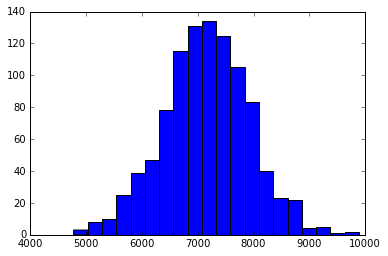

In [190]:
y = []
x = AttendanceGenerator(room_stack=[],time_range=10800)
for i in range(1000):
    #y.append(x.lifts[0].gen_close_door())
    #print(i)
    y.append(x.generate())
plt.hist(y,bins=20)

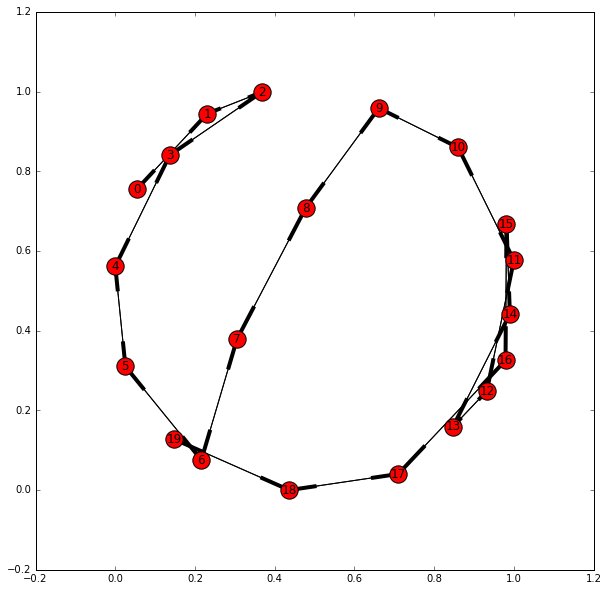

In [203]:
one_lift = create_lift(20)
plt.figure(figsize=(10,10))
nx.draw_networkx(one_lift,pos=nx.spring_layout(one_lift))
plt.show()

In [23]:
# make a graph network of the floor
lifts_graph = []
for x in range(lift_number):
    lifts_graph.append(create_lift(number_of_floor))

In [24]:
lifts_graph